# Predicting when a company will send it's next marketing email

This project aims to predict when a company will send it's next marketing email. The data comes from [MailCharts](https://www.mailcharts.com/).

Predicting when your competitors will send their next marketing blast allows you to get ahead of the game and send your email before they do.

- Sample data: http://share.mailcharts.com/0b141Z3c1M40
- All data: _coming soon_

In [374]:
# Import libraries and dependencies

from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split 

In [375]:
# Import the data

df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(4585, 6)

In [376]:
# Add first set of features we need

df['sent_time'] = pd.to_datetime(df.sent_at)
df['hour'] = df.sent_time.apply(lambda x: x.hour)
df['day'] = df.sent_time.apply(lambda x: x.day)
df['month'] = df.sent_time.apply(lambda x: x.month)
df['year'] = df.sent_time.apply(lambda x: x.year)
df['day_of_week'] = df.sent_time.dt.weekday_name 
df['day_of_week_num'] = df.sent_time.dt.weekday 
df['weekend'] = df.day_of_week.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
df["weeknum"] = df.sent_time.dt.weekofyear
df["am_pm"] = df.sent_time.apply(lambda x: 1 if x.strftime('%p') == "AM" else 0)

In [377]:
start_time = timeit.default_timer()

df = df.sort_values("sent_at", ascending=True)

results = []
companies = df["company_id"].unique()

for c in companies:
    company_emails = df[df["company_id"] == c]
    previous_email_sent_at = None

    for index, row in company_emails.iterrows():
        if previous_email_sent_at == None:    
            previous_email_sent_at = row["sent_at"]
            df.loc[index, "prev_email"] = 0
        else:
            df.loc[index, "prev_email"] = previous_email_sent_at
            previous_email_sent_at = row["sent_at"]

elapsed = timeit.default_timer() - start_time
print(elapsed)

7.888042259997746


In [378]:
# # Gather when the previous email was sent
# ## TODO: HOW CAN WE MAKE THIS RUN FASTER

# start_time = timeit.default_timer()

# df = df.sort_values("sent_at", ascending=False)
# results = []
# for index, row in df.iterrows():
#     company_emails = df[df["company_id"] == row["company_id"]]
#     earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
#     if len(earlier_emails) > 0:
#         results.append(earlier_emails[0])
#         continue
#     else:
#         results.append(None)

# # Save the results to our dataframe
# df["prev_email"] = results

# elapsed = timeit.default_timer() - start_time
# print(elapsed)
# THIS USE TO TAKE 91 SECONDS

In [379]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == 0:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["delta_in_seconds"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

In [380]:
# QA that we only have 1 time_delta with a value of 0
## TODO: Carl will need to re-pull this data to make sure only unique emails are shown. Here we see email 3529 and 3530 are the same.

df[df["delta_in_seconds"] == 0]["company_name"].value_counts()

Adorama                2
Ace & Everett          1
Allurez                1
Ace & Tate             1
Abercrombie & Fitch    1
10DollarMall           1
1-800-Flowers.com      1
1000Bulbs.com          1
AllModern              1
A'GACI                 1
Name: company_name, dtype: int64

In [381]:
# Add a few more features which will make it easier to read our time deltas

df["delta_in_hours"] = df["delta_in_seconds"] / 60 / 60
df["delta_in_days"] = df["delta_in_seconds"] / 60 / 60 / 24

In [382]:
# Get company dummies. This will help us calculate each prediction at a company level

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

# Merge both dataframes

df = pd.merge(df, dummy_company, right_index=True, left_index=True)

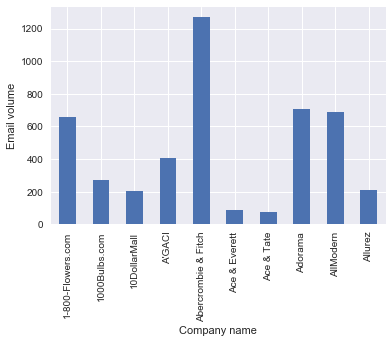

In [383]:
# Visualize  send volume to understand the data a bit better
# Takeaway #1: Email volume varies drastically by company.
# Also, we may have some heavy senders. 1,200+ emails by abercrombie seems extremely high.

email_counts_sum = df.groupby(["company_name"])["delta_in_seconds"].count()
bars = email_counts_sum.plot(kind='bar')
bars.set_ylabel("Email volume")
bars.set_xlabel("Company name")

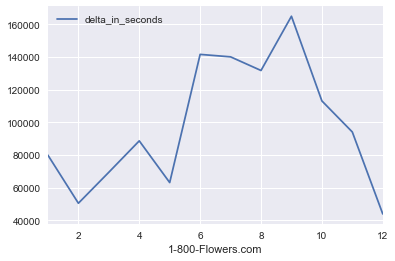

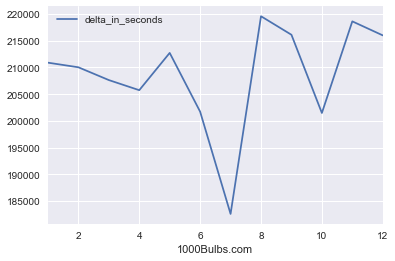

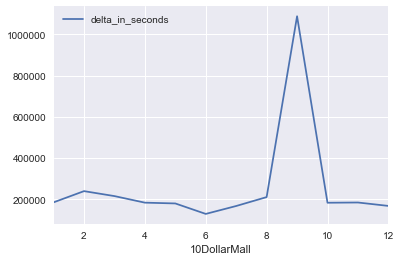

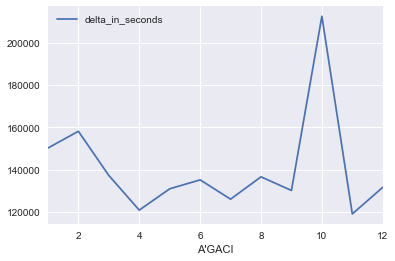

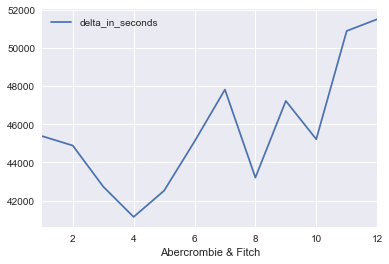

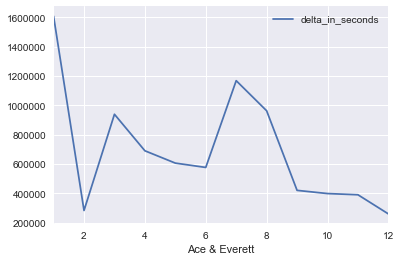

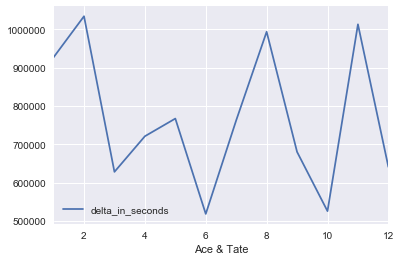

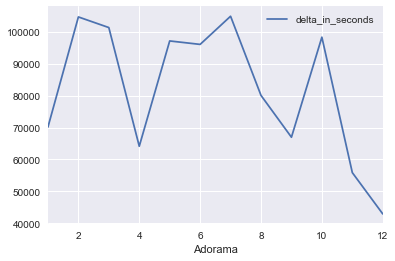

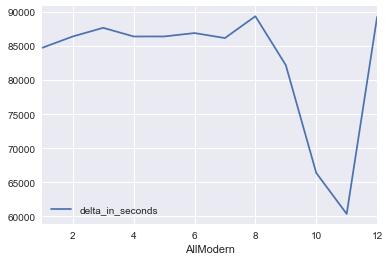

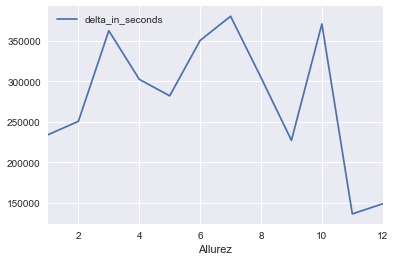

In [384]:
# Let's analyze the sending behavior of these companies
# Takeaway #2: Every company has their own sending behavior!
# Takeaway #3: Seasonality is likely to impact email frequency.
# Note: Spikes == more time in between emails

time_delta_average_by_month = df.groupby(by=['company_name', 'month'])["delta_in_seconds"].mean().reset_index()
c_name = time_delta_average_by_month["company_name"].unique()

for i in c_name:
    company = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].reset_index()
    plot = company.plot(x="month", y="delta_in_seconds")
    plot.set_xlabel(i)


In [385]:
# It's not 100% clear here, but it looks like industry could be a helpful feature to include in our model
# Let's visualize this

df.groupby(["industry_name", "company_name"]).delta_in_seconds.mean().astype(int).reset_index().sort_values("delta_in_seconds")

,industry_name,company_name,delta_in_seconds
6,retail,Abercrombie & Fitch,44965
3,photography,Adorama,80289
0,e-commerce,AllModern,82759
4,retail,1-800-Flowers.com,86788
5,retail,A'GACI,139194
1,lighting,1000Bulbs.com,207690
2,other,Ace & Tate,728605


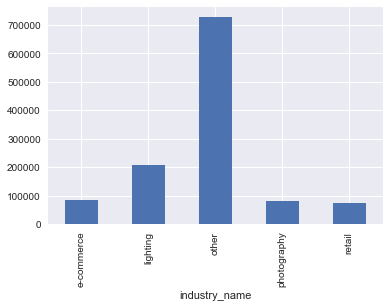

In [386]:
# Visualize the send volume to understand the data a bit better
# Takeaway #4: Consider adding industry as a feature

email_between_time_avg = df.groupby(["industry_name"]).delta_in_seconds.mean()
email_between_time_avg.plot(kind='bar')

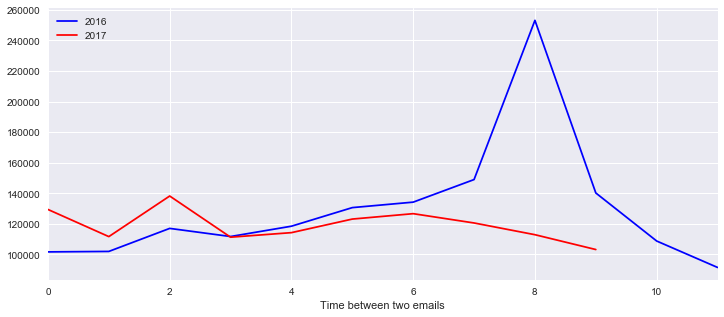

In [387]:
# Let's analyze all of the data by month to see how our 2 years of data compare
# TODO: Make the x-axis start from 1 (January) and not 0

plt.figure(figsize=(12,5))
plt.xlabel('Time between two emails')

df1 = df[df["year"] == 2016].groupby("month").delta_in_seconds.mean().reset_index()
df2 = df[df["year"] == 2017].groupby("month").delta_in_seconds.mean().reset_index()

ax1 = df1.delta_in_seconds.plot(color='blue', label='2016')
ax2 = df2.delta_in_seconds.plot(color='red', label='2017')

h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.show()

# We can see the impact of seasonality

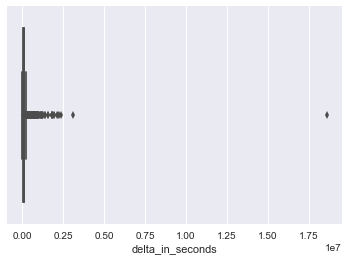

In [388]:
# Next, let's look at the distribution of our email delta

sns.boxplot(x=df["delta_in_seconds"])

# Look at that...! We have some outliers. Let's remove them.

(4585, 30)
(4557, 30)
We removed 28 outliers


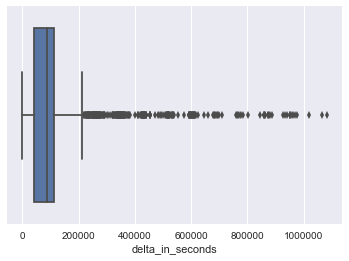

In [389]:
# Remove prev_time_delta outliers

stdev = df.delta_in_seconds.std()
mean = df.delta_in_seconds.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = df[(df.delta_in_seconds >=lower_bound) & (df.delta_in_seconds <= upper_bound)]

print(df.shape)
print(non_outliers.shape)
print("We removed", df.shape[0] - non_outliers.shape[0], "outliers")
sns.boxplot(x=non_outliers["delta_in_seconds"])

In [390]:
# This looks good, let's assign this back to our df variable

df = non_outliers

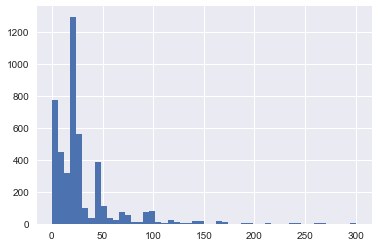

In [391]:
# Let's get a graps of how our data is distributed

df.delta_in_hours.hist(bins = 50)

# Look at that, it's left skewed!

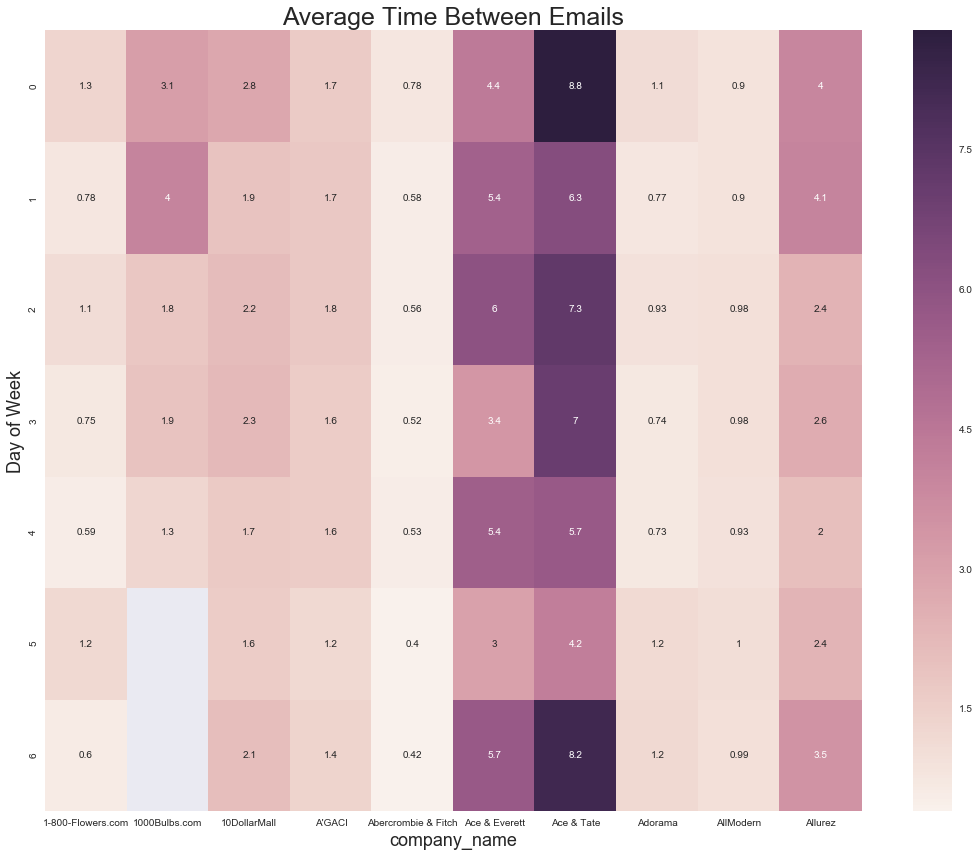

In [392]:
# Let's build a heatmap!

f = plt.figure(1, figsize = (15,12))
pvt = pd.pivot_table(data=df,values='delta_in_days',index='day_of_week_num', columns='company_name')
sns.heatmap(pvt, annot=True)
plt.title('Average Time Between Emails',fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('company_name',fontsize=18)
plt.ylabel('Day of Week',fontsize=18)
plt.tight_layout()

plt.show()

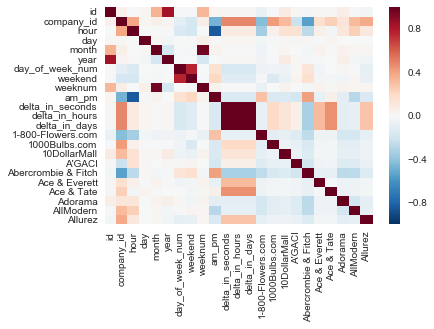

In [395]:
sns.heatmap(df.corr())

In [99]:
# Let's try creating a new feature for retail / not retail

df['retail_ecommerce']=(df.industry_name=='retail') ^ (df.industry_name=='e-commerce')

In [100]:
# Let's analyze seasonality

def season_map(month):
    season=''
    if month <=3:
        season='Spring'
    elif month<=6:
        season='Summer'
    elif month<=9:
        season='Fall'
    else: 
        season='Winter'
    return season

df['season']=df.month.apply(lambda x:season_map(x))
df['season_num'] = pd.Categorical(df.season).codes

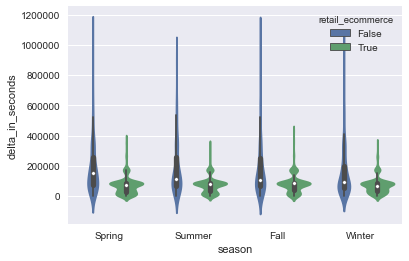

In [101]:
sns.violinplot(x='season', y='delta_in_seconds', data=df, hue='retail_ecommerce' )

## Done with EDA

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

In [236]:
for c in df.columns:
    print(c)

id
company_name
company_id
subject
sent_at
industry_name
sent_time
hour
day
month
year
day_of_week
day_of_week_num
weekend
weeknum
am_pm
prev_email
delta_in_seconds
delta_in_hours
delta_in_days
1-800-Flowers.com
1000Bulbs.com
10DollarMall
A'GACI
Abercrombie & Fitch
Ace & Everett
Ace & Tate
Adorama
AllModern
Allurez
season
season_num
retail_ecommerce


In [333]:
# The modeling begins

target = df.delta_in_seconds
companies = df["company_name"].unique()
features_of_interest = np.append([companies], ['month', 'weeknum', 'am_pm', 'season_num', 'weekend', 'retail_ecommerce'])
features = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3417, 16)
(3417,)
(1140, 16)
(1140,)


In [334]:
# Initialize our fit our model

lg = LinearRegression()
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [335]:
y_pred = lg.predict(X_test)
lg.score(X_test, y_test)

0.5269180577994933

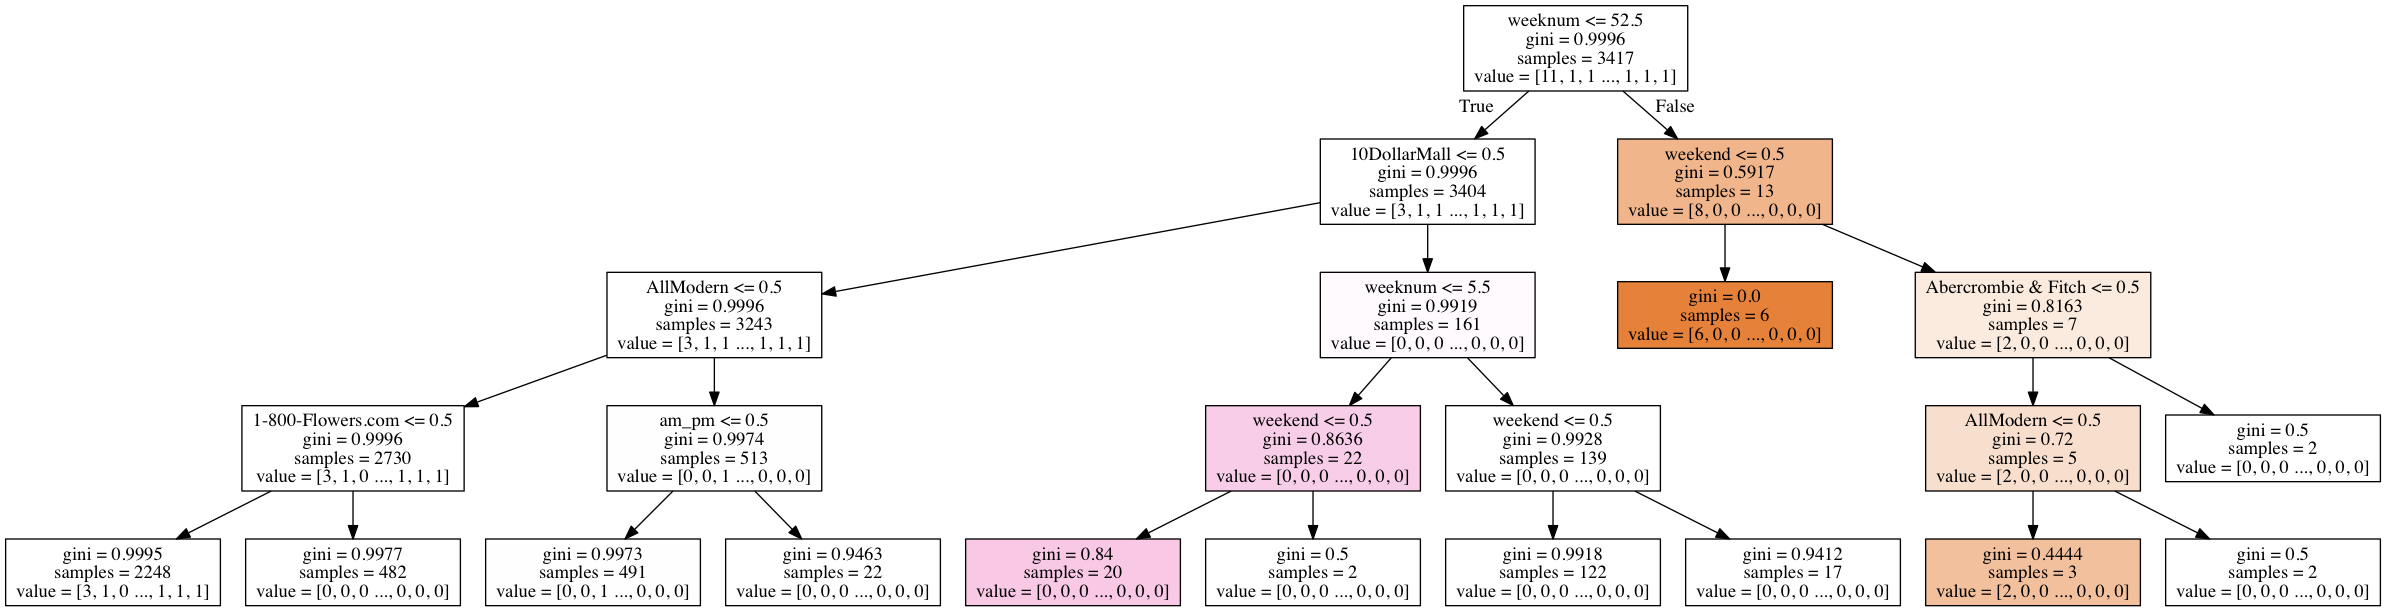

In [363]:
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

decision_tree = tree.DecisionTreeClassifier(max_depth=4)
decision_tree.fit(X_train, y_train)

dot_data = tree.export_graphviz(
    decision_tree,
    out_file=None,
    feature_names=features_of_interest,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [364]:
print(decision_tree.score(X_test, y_test))

0.00350877192982


In [368]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.402127793185


In [397]:
## Homework
# Get project on Floyd https://www.floydhub.com/
# Spend some time on feature engineering
# Use different models
### Adaboost
### XG boost